In [1]:
!pip -q install timm==1.0.9

import os, random, math, time
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

DATA_DIR = Path("/kaggle/input/brain-tumor-mri-classification")
TRAIN_DIR = DATA_DIR/"Training"/"Training"
TEST_DIR  = DATA_DIR/"Testing"/"Testing"


print("Train classes:", sorted([d.name for d in TRAIN_DIR.iterdir() if d.is_dir()]))
print("Test  classes:", sorted([d.name for d in TEST_DIR.iterdir() if d.is_dir()]))

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 29.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

train_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.1,0.1,0.1,0.05),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

val_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_tfms)
test_ds  = datasets.ImageFolder(TEST_DIR,  transform=val_tfms)

BATCH_SIZE = 32
NUM_WORKERS = 2

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

class_names = train_ds.classes
num_classes = len(class_names)
print("Classes:", class_names, " -> ", num_classes)


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']  ->  4


In [3]:
import timm
def build_vit(num_classes: int):
    try:
        model = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=num_classes)
        return model
    except Exception as e:
        print("timm недоступний, fallback на torchvision vit_b_16:", e)
        from torchvision.models import vit_b_16, ViT_B_16_Weights
        weights = ViT_B_16_Weights.DEFAULT
        model = vit_b_16(weights=weights)
        in_feats = model.heads.head.in_features
        model.heads.head = nn.Linear(in_feats, num_classes)
        return model

model = build_vit(num_classes).to(DEVICE)

criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5, weight_decay=1e-4)

num_epochs = 30  
total_steps = num_epochs * len(train_loader)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps)

scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

/tmp/ipykernel_48/1565335784.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


In [6]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = np.inf
        self.count = 0
        self.should_stop = False

    def step(self, current):

        if current < self.best - self.min_delta:
            self.best = current
            self.count = 0
        else:
            self.count += 1
            if self.count >= self.patience:
                self.should_stop = True

early_stopper = EarlyStopping(patience=5, min_delta=1e-4)


In [8]:
def train_one_epoch(model, loader, optimizer, scaler, scheduler, device):
    model.train()
    running_loss, running_correct, total = 0.0, 0, 0
    for imgs, labels in tqdm(loader, leave=False):
        imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            logits = model(imgs)
            loss = criterion(logits, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        running_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(1)
        running_correct += (preds == labels).sum().item()
        total += imgs.size(0)
    return running_loss/total, running_correct/total

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    running_loss, running_correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []
    for imgs, labels in tqdm(loader, leave=False):
        imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            logits = model(imgs)
            loss = criterion(logits, labels)
        running_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(1)
        running_correct += (preds == labels).sum().item()
        total += imgs.size(0)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

    all_preds  = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return running_loss/total, running_correct/total, all_preds, all_labels


In [9]:
history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
best_acc, best_path = 0.0, "/kaggle/working/vit_brain_mri_best.pt"

global_step = 0
for epoch in range(1, num_epochs+1):
    tl, ta = train_one_epoch(model, train_loader, optimizer, scaler, scheduler, DEVICE)
    vl, va, vp, vlb = evaluate(model, test_loader, DEVICE)

    history["train_loss"].append(tl); history["train_acc"].append(ta)
    history["val_loss"].append(vl);   history["val_acc"].append(va)

    if va > best_acc:
        best_acc = va
        torch.save({"model": model.state_dict(), "classes": class_names}, best_path)

    print(f"Epoch {epoch:02d}/{num_epochs} | "
          f"train_loss={tl:.4f} acc={ta:.4f} | "
          f"val_loss={vl:.4f} acc={va:.4f} | best_acc={best_acc:.4f}")

    early_stopper.step(vl)
    if early_stopper.should_stop:
        print(f"Early stopping: валід. втрата не покращується {early_stopper.patience} епох поспіль.")
        break


  0%|          | 0/1003 [00:00<?, ?it/s]

/tmp/ipykernel_48/2040878359.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


  0%|          | 0/251 [00:00<?, ?it/s]

/tmp/ipykernel_48/2040878359.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 01/30 | train_loss=0.3029 acc=0.9581 | val_loss=0.2314 acc=0.9880 | best_acc=0.9880


  0%|          | 0/1003 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eb1737c39c0>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7eb1737c39c0>
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

     if w.is_alive(): 
          ^ ^ ^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^^    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3

  0%|          | 0/251 [00:00<?, ?it/s]

Epoch 02/30 | train_loss=0.2303 acc=0.9889 | val_loss=0.2221 acc=0.9928 | best_acc=0.9928


  0%|          | 0/1003 [00:00<?, ?it/s]

  0%|          | 0/251 [00:00<?, ?it/s]

Epoch 03/30 | train_loss=0.2230 acc=0.9919 | val_loss=0.2191 acc=0.9934 | best_acc=0.9934


  0%|          | 0/1003 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eb1737c39c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eb1737c39c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

  0%|          | 0/251 [00:00<?, ?it/s]

Epoch 04/30 | train_loss=0.2203 acc=0.9926 | val_loss=0.2273 acc=0.9889 | best_acc=0.9934


  0%|          | 0/1003 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eb1737c39c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7eb1737c39c0>^
^Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^^    self._shutdown_workers()^^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^    ^if w.is_alive():^
^ ^ ^

  0%|          | 0/251 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eb1737c39c0><function _MultiProcessingDataLoaderIter.__del__ at 0x7eb1737c39c0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7eb1737c39c0>    if w.is_alive():
if w.is_alive():
Traceback (most recent call last):

   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, 

Epoch 05/30 | train_loss=0.2182 acc=0.9937 | val_loss=0.2215 acc=0.9924 | best_acc=0.9934


  0%|          | 0/1003 [00:00<?, ?it/s]

  0%|          | 0/251 [00:00<?, ?it/s]

Epoch 06/30 | train_loss=0.2146 acc=0.9952 | val_loss=0.2501 acc=0.9820 | best_acc=0.9934


  0%|          | 0/1003 [00:00<?, ?it/s]

  0%|          | 0/251 [00:00<?, ?it/s]

Epoch 07/30 | train_loss=0.2158 acc=0.9945 | val_loss=0.2107 acc=0.9961 | best_acc=0.9961


  0%|          | 0/1003 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eb1737c39c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eb1737c39c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

  0%|          | 0/251 [00:00<?, ?it/s]

Epoch 08/30 | train_loss=0.2100 acc=0.9969 | val_loss=0.2139 acc=0.9948 | best_acc=0.9961


  0%|          | 0/1003 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eb1737c39c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
  Exception ignored in:   <function _MultiProcessingDataLoaderIter.__del__ at 0x7eb1737c39c0>  
 ^Traceback (most recent call last):
^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^^^    ^^self._shutdown_workers()^
^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^    if w.is_alive():

  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
     assert self._parent_pid == os.getpid(), 'can only test a child process' 
          ^ ^ ^ ^  ^ ^^^^^^^^^^^^^^^^
  F

  0%|          | 0/251 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eb1737c39c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
self._shutdown_workers()    
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
Exception ignored in:     if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7eb1737c39c0>

Traceback (most recent call last):
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
     self._shutdown_workers() 
    File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
     Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7eb1737c39c0>if w.is_alive():^
^Traceback (most recent call last):

^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", li

Epoch 09/30 | train_loss=0.2108 acc=0.9965 | val_loss=0.2109 acc=0.9966 | best_acc=0.9966


  0%|          | 0/1003 [00:00<?, ?it/s]

  0%|          | 0/251 [00:00<?, ?it/s]

Epoch 10/30 | train_loss=0.2098 acc=0.9969 | val_loss=0.2217 acc=0.9923 | best_acc=0.9966


  0%|          | 0/1003 [00:00<?, ?it/s]

  0%|          | 0/251 [00:00<?, ?it/s]

Epoch 11/30 | train_loss=0.2098 acc=0.9965 | val_loss=0.2178 acc=0.9943 | best_acc=0.9966


  0%|          | 0/1003 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eb1737c39c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eb1737c39c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

  0%|          | 0/251 [00:00<?, ?it/s]

Epoch 12/30 | train_loss=0.2055 acc=0.9983 | val_loss=0.2061 acc=0.9980 | best_acc=0.9980


  0%|          | 0/1003 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eb1737c39c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
    Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7eb1737c39c0>
 Exception ignored in:  Traceback (most recent call last):
^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7eb1737c39c0>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
self._shutdown_workers()^    
^^self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", l

  0%|          | 0/251 [00:00<?, ?it/s]

Epoch 13/30 | train_loss=0.2059 acc=0.9982 | val_loss=0.2169 acc=0.9938 | best_acc=0.9980


  0%|          | 0/1003 [00:00<?, ?it/s]

  0%|          | 0/251 [00:00<?, ?it/s]

Epoch 14/30 | train_loss=0.2060 acc=0.9981 | val_loss=0.2082 acc=0.9973 | best_acc=0.9980


  0%|          | 0/1003 [00:00<?, ?it/s]

  0%|          | 0/251 [00:00<?, ?it/s]

Epoch 15/30 | train_loss=0.2043 acc=0.9989 | val_loss=0.2073 acc=0.9981 | best_acc=0.9981


  0%|          | 0/1003 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eb1737c39c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eb1737c39c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

  0%|          | 0/251 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eb1737c39c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eb1737c39c0>  
 Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
       self._shutdown_workers() 
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^^    ^if w.is_alive():^
^ ^ ^  ^ ^ ^ ^^^^^^^^^^^^^^

Epoch 16/30 | train_loss=0.2042 acc=0.9988 | val_loss=0.2079 acc=0.9971 | best_acc=0.9981


  0%|          | 0/1003 [00:00<?, ?it/s]

  0%|          | 0/251 [00:00<?, ?it/s]

Epoch 17/30 | train_loss=0.2035 acc=0.9991 | val_loss=0.2091 acc=0.9970 | best_acc=0.9981
Early stopping: валід. втрата не покращується 5 епох поспіль.


In [10]:
checkpoint = torch.load(best_path, map_location=DEVICE)
model.load_state_dict(checkpoint["model"])
model.eval()

val_loss, val_acc, y_pred, y_true = evaluate(model, test_loader, DEVICE)
print(f"\nFinal test accuracy: {val_acc:.4f} (loss {val_loss:.4f})")

report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print("\nClassification report:\n", report)


  0%|          | 0/251 [00:00<?, ?it/s]

/tmp/ipykernel_48/2040878359.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):



Final test accuracy: 0.9981 (loss 0.2073)

Classification report:
               precision    recall  f1-score   support

      glioma     0.9989    0.9947    0.9968      1886
  meningioma     0.9947    0.9973    0.9960      1879
     notumor     0.9996    1.0000    0.9998      2317
   pituitary     0.9990    1.0000    0.9995      1938

    accuracy                         0.9981      8020
   macro avg     0.9980    0.9980    0.9980      8020
weighted avg     0.9981    0.9981    0.9981      8020



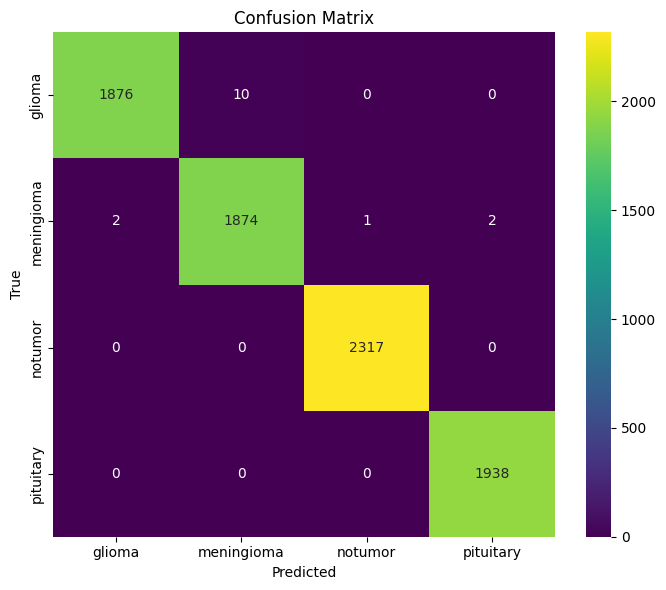

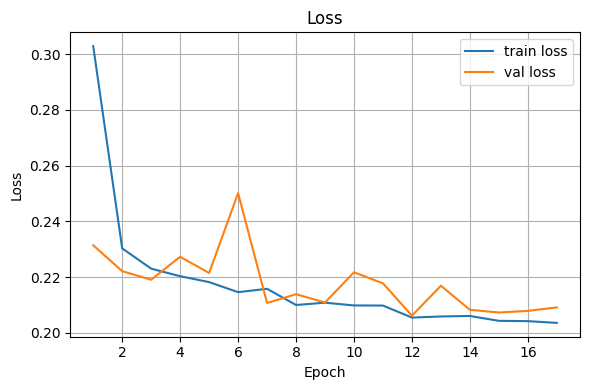

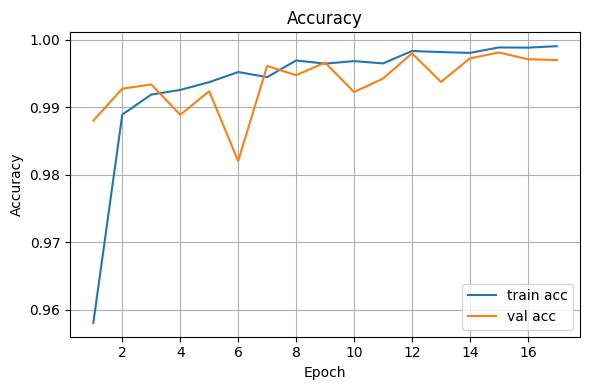

In [11]:
cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

ep = range(1, len(history["train_loss"])+1)
plt.figure(figsize=(6,4))
plt.plot(ep, history["train_loss"], label="train loss")
plt.plot(ep, history["val_loss"],   label="val loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss"); plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(ep, history["train_acc"], label="train acc")
plt.plot(ep, history["val_acc"],   label="val acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy"); plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()


In [12]:
from PIL import Image

def predict_image(path: str):
    img = Image.open(path).convert("RGB")
    x = val_tfms(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad(), torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
        logits = model(x)
        prob = torch.softmax(logits, dim=1).squeeze().cpu().numpy()
    pred_idx = int(np.argmax(prob))
    return class_names[pred_idx], prob[pred_idx]


samples = []
for c in class_names:
    folder = TEST_DIR/c
    img_path = next(iter([p for p in folder.iterdir() if p.suffix.lower() in [".jpg",".jpeg",".png"]]))
    samples.append(str(img_path))

for p in samples:
    lbl, pr = predict_image(p)
    print(f"{Path(p).name:30s} -> {lbl:10s} ({pr:.3f})")


aug_0_1131.jpeg                -> glioma     (0.962)
aug_0_9187.jpeg                -> meningioma (0.965)
aug_0_9620.jpeg                -> notumor    (0.963)
aug_0_1131.jpeg                -> pituitary  (0.964)


/tmp/ipykernel_48/970072767.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
